In [1]:
%pylab inline

from itertools import product
import numpy as np
from scipy.optimize import minimize
import pickle
import time

def printTime() :
    print(time.strftime("%H:%M:%S"));
    
from util import *
from santa_hmm import *
    
%load_ext cython

Populating the interactive namespace from numpy and matplotlib


# Santa Claus Example for the CRF practicum


## Where is Santa? Find out Conditional Random Fields

Little Mary wakes up in the middle of the night of Christmas eve. She heard
some noise. Probably Santa Clause is coming with her presents! She is not allowed to leave her room, 
so she cannot check where Santa currently is. She tries to infer his position from sounds, the light that enters the room through the window and the keyhole and the smell.

Santa can be either *absent*, on his *sleigh*, in the *chimney* or at the
*Christmas tree*. In order to get to the Christmas tree, he has to go
through the chimney, because the doors are locked. 

Since Hidden Markov Models are not (yet) in the curriculum of elementary
school, Mary needs your help to find out the whereabouts of Santa.

In [2]:
#build cython
!python setup.py build_ext --inplace

running build_ext
copying build/lib.linux-x86_64-2.7/marycrf/crf_core.so -> marycrf
copying build/lib.linux-x86_64-2.7/marycrf/crf_features.so -> marycrf


In [3]:
!ls -l

total 6844
-rw-rw-r-- 1 martin martin 5857611 Mär  2 17:33 beatles_data.npz
drwxrwxr-x 6 martin martin    4096 Mär  2 19:07 build
-rw-rw-r-- 1 martin martin  423492 Mär  2 18:01 crf_chords_data.ipynb
-rw-rw-r-- 1 martin martin  180626 Apr  3 12:41 crf_chords_martin-Copy1.ipynb
-rw-rw-r-- 1 martin martin  205207 Jun 18 18:06 crf_chords_martin.ipynb
-rwxrwxr-x 1 martin martin  211501 Mär  2 17:57 crf_santa_adder_cython.ipynb
-rw-rw-r-- 1 martin martin    8964 Mär  2 17:57 hmm.py
-rw-rw-r-- 1 martin martin   30143 Mär 23 17:48 ltest.txt
-rw-rw-r-- 1 martin martin   30576 Apr  3 12:40 ltrain.txt
drwxrwxr-x 3 martin martin    4096 Jun 18 18:35 marycrf
drwxrwxr-x 2 martin martin    4096 Jun 18 18:35 __pycache__
-rw-rw-r-- 1 martin martin    9039 Mär  2 17:57 santa_hmm.py
-rwxrwxr-x 1 martin martin    1029 Mär  2 19:06 setup.py
drwxrwxr-x 2 martin martin    4096 Dez 28 11:45 test
-rw-rw-r-- 1 martin martin     988 Mär  2 17:33 util.py


## CRF Definition

In [4]:
from marycrf import *

## HMM definition

In [5]:
pi = array([1, 0, 0, 0])

# hidden states: 0 = absent, 1 = sleigh, 2 = chimney, 3 = christmas tree
A = array([[0.8, 0.2, 0.0, 0.0],
           [0.2, 0.6, 0.2, 0.0],
           [0.0, 0.4, 0.2, 0.4],
           [0.0, 0.0, 0.4, 0.6]])

#A = np.ones((4,4)) * (1.0/4)

# observation probabilites: noise (0 = silence, 1 = rumbling, 2 = crackle)
B1 = array([[0.9,  0.1, 0.0, 0.2],
            [0.05, 0.4, 1.0, 0.1],
            [0.05, 0.5, 0.0, 0.7]])
# observation probabilities: light (0 = bright light, 1 = dimmed light, 2 = dark)
B2 = array([[0.1, 0.1, 0.0, 0.4],
            [0.1, 0.3, 0.1, 0.4],
            [0.8, 0.6, 0.9, 0.2]])
# observation probabilities: smell (0 = cinnamon, 1 = popcorn, 2 = no particular smell)
B3 = array([[0.2, 0.2, 0.2, 0.2],
            [0.1, 0.1, 0.1, 0.1],
            [0.7, 0.7, 0.7, 0.7]])

model = HMM(pi, A, B1, B2, B3)

# observation probabilites: noise (0 = silence, 1 = rumbling, 2 = crackle)
B1G = array([[1.0,  1.0, 1.0, 1.0],
            [0.5, 1.0, 0.1, 3.8]])

# observation probabilities: light (0 = bright light, 1 = dimmed light, 2 = dark)
B2G = array([[5.0,  6.0, 7.0, 8.0],
            [0.9, 2.0, 3.1, 1.8]])
# observation probabilities: smell (0 = cinnamon, 1 = popcorn, 2 = no particular smell)
B3G = array([[9.0,  10.0, 11.0, 12.0],
            [7.5, 0.6, 9.1, 6.8]])

modelG = HMM(pi, A, B1G, B2G, B3G)

## CRF definition (discrete)

In [6]:
obsIndex = np.array(list(np.ndindex((3,3,4))))
transIndex = np.array(list(np.ndindex((4,4))))
cweights = np.log(np.concatenate((B1.flatten(),B2.flatten(),B3.flatten(),A.flatten()))+0.000001)  # To avoid Problems with np.log(0) = -Inf and Weight = 0 --> -Inf * 0 = Nan


#cython CRF
cyObsFuncs = [FeatureFunctionObservation(x[2],x[0],x[1]) for x in obsIndex]
cyTransFuncs = [FeatureFunctionTransition(x[0], x[1]) for x in transIndex]
cyFeatureFuncs = np.array(cyObsFuncs + cyTransFuncs)
cycrf = CyCRF(len(pi),cyFeatureFuncs)
cycrf.pi = pi * 1.0
cycrf.weights = cweights;


## CRF definition (gaussian)

In [7]:
obsIndex = np.array(list(np.ndindex((3,4))))
BG = np.array([B1G,B2G,B3G])
sigmas = BG[:,1,:]
means = BG[:,0,:]
wxsq =  -1.0/(np.power(sigmas,2)*2.0)
wx = means/np.power(sigmas,2)
w1 = np.sum((-np.power(means,2)/(np.power(sigmas,2)*2.0)) - np.log(np.sqrt(2 * np.pi * np.power(sigmas,2))),0)
cweightsG = np.concatenate((wxsq.flatten(),wx.flatten(),w1, np.log(A.flatten()+0.000001)))

#cython CRF
cyObsFuncsG = list(map(FeatureFunctionCurrentStateXSq,obsIndex[:,1],obsIndex[:,0])) + list(map(FeatureFunctionCurrentStateX,obsIndex[:,1],obsIndex[:,0])) + list(map(FeatureFunctionCurrentStateConst,range(0,4)))
cyFeatureFuncsG = np.array(cyObsFuncsG + cyTransFuncs)
cycrfG = CyCRF(len(pi),cyFeatureFuncsG)
cycrfG.pi = pi * 1.0
cycrfG.weights = cweightsG;


In [8]:
wxsq

array([[ -2.00000000e+00,  -5.00000000e-01,  -5.00000000e+01,
         -3.46260388e-02],
       [ -6.17283951e-01,  -1.25000000e-01,  -5.20291363e-02,
         -1.54320988e-01],
       [ -8.88888889e-03,  -1.38888889e+00,  -6.03791813e-03,
         -1.08131488e-02]])

## Create data and save it

In [9]:
n_samples = 50
len_sequence = 50
hidden_states_sequences = np.empty((n_samples, len_sequence + 1), dtype=int)
observations = np.empty((n_samples,3, len_sequence), dtype=int)

for i in range(n_samples) :
    x, y = generate_sequence(model, len_sequence);
    hidden_states_sequences[i, :] = x
    observations[i,:,:] = y
    
fln_y = "santa_claus_crf_hidden_" + str(len_sequence) + ".dump"
fln_x = "santa_claus_crf_observed_" + str(len_sequence) + ".dump"

In [10]:
n_samples = 50
len_sequence = 200
hidden_states_sequencesG = np.empty((n_samples, len_sequence + 1), dtype=int)
observationsG = np.empty((n_samples,3, len_sequence), dtype=double)

for i in range(n_samples) :
    x, y = generate_sequenceG(modelG, len_sequence)
    hidden_states_sequencesG[i, :] = x
    observationsG[i,:,:] = y

fln_yG = "santa_claus_crf_hidden_G_" + str(len_sequence) + ".dump"
fln_xG = "santa_claus_crf_observed_G_" + str(len_sequence) + ".dump"

In [11]:
sample_y = hidden_states_sequences[0]
sample_x = observations[0]

sample_yl = [hidden_states_sequences[x] for x in range(hidden_states_sequences.shape[0])]
sample_xl = [(observations[x] *1.0) for x in range(observations.shape[0])]

sample_yG = hidden_states_sequencesG[0]
sample_xG = observationsG[0]

sample_yGl = [hidden_states_sequencesG[x] for x in range(hidden_states_sequencesG.shape[0])]
sample_xGl = [(observationsG[x] *1.0) for x in range(observationsG.shape[0])]

In [12]:
len(sample_x[0])

50

# Forward with HMM and CRF (python, cython, fast)

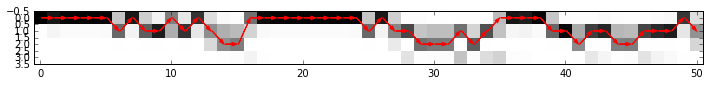

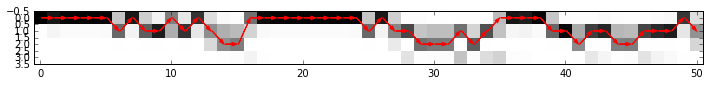

In [12]:
res = forwardHMM(model,sample_x)
plot_states(res.argmax(1),res)

res = np.array(cycrf.forward(sample_x*1.0,1))
plot_states(res.argmax(1),res)

# ForwardBackward with HMM and CRF (python, cython, fast)

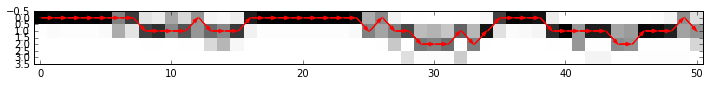

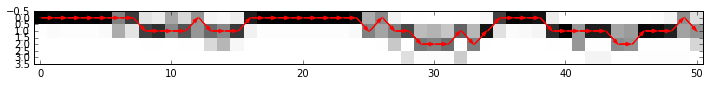

In [13]:
res = forward_backwardHMM(model,sample_x)
plot_states(res.argmax(1),res)

res = cycrf.forward_backward(sample_x*1.0)
plot_states(res.argmax(1),res)

# Viterbi with HMM and CRF (python, cython, fast)

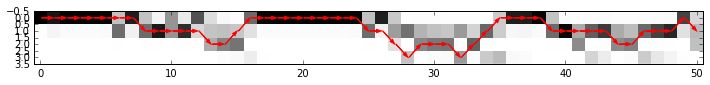

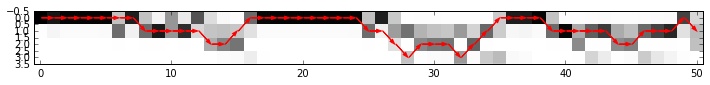

In [14]:
res = viterbiHMM(model,sample_x)
plot_states(res[0],res[1])

res = cycrf.viterbi(sample_x*1.0)
plot_states(res[0],res[1])

# Learning Parameters

In [15]:
#generate initials
iniGuess = cycrf.__generate_initial_weights()

In [ ]:
#timing for weight optimization
%timeit cycrf.__optimal_weights_NM([sample_y],[sample_x*1.0],iniGuess,300);
%timeit cycrf.__optimal_weights_BFGS([sample_y],[sample_x*1.0],iniGuess);

/home/martin/anaconda3/lib/python3.4/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: divide by zero encountered in log
  return function(*(wrapper_args + args))
/home/martin/anaconda3/lib/python3.4/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: divide by zero encountered in log
  return function(*(wrapper_args + args))


In [ ]:
printTime()
lweightsNM = cycrf.train_NM(sample_yl,sample_xl,3000);
printTime()

In [ ]:
printTime()
lweightsBFGS = cycrf.train_BFGS(sample_yl,sample_xl);
printTime()

# Viterbi for CRF with weights (calculated from HMM, initial, optimized)

NameError: name 'lweightsNM' is not defined

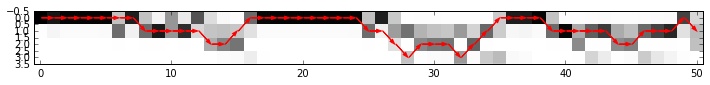

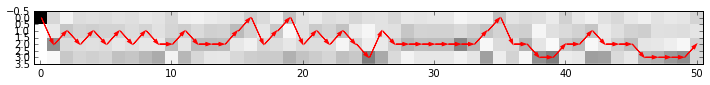

In [16]:
# with original weights
res = cycrf.__viterbi_Weights(cweights,sample_x*1.0)
plot_states(res[0],res[1])

# with initial guess
res = cycrf.__viterbi_Weights(iniGuess,sample_x*1.0)
plot_states(res[0],res[1])

# with optimized weights
res = cycrf.__viterbi_Weights(lweightsNM,sample_x*1.0)
plot_states(res[0],res[1])

# with optimized weights
res = cycrf.__viterbi_Weights(lweightsBFGS,sample_x*1.0)
plot_states(res[0],res[1])

# Gaussian Stuff

# Forward with HMM and CRF

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


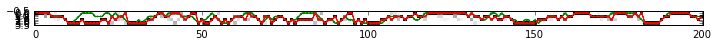

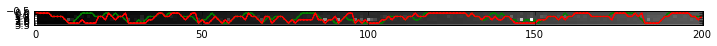

In [17]:
res = forwardHMMG(modelG,sample_xG)
plot_states(res.argmax(1),res,sample_yG)

res = cycrfG.forward_Log(sample_xG*1.0,0)
plot_states(res.argmax(1),res,sample_yG)

# ForwardBackward with HMM and CRF

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


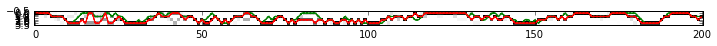

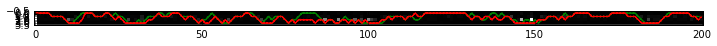

In [18]:
res = forward_backwardHMMG(modelG,sample_xG)
plot_states(res.argmax(1),res,sample_yG)

res = cycrfG.forward_backward_Log(sample_xG*1.0,0)
plot_states(res.argmax(1),res,sample_yG)

# Viterbi with HMM and CRF

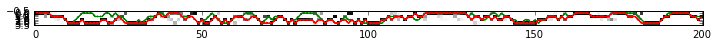

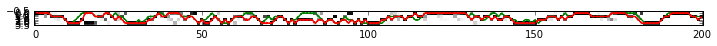

In [19]:
res = viterbiHMMG(modelG,sample_xG)
plot_states(res[0],res[1],sample_yG)

res = cycrfG.viterbi(sample_xG*1.0)
plot_states(res[0],res[1],sample_yG)

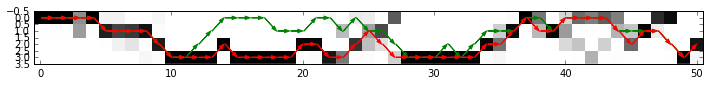

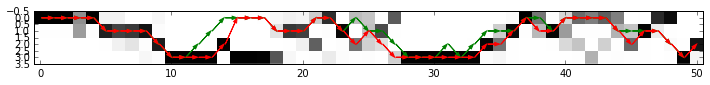

In [24]:
res = viterbiHMMG(modelG,sample_xG[:,:50])
plot_states(res[0],res[1],sample_yG[:50])

res = cycrfG.viterbi(sample_xG[:,:50]*1.0)
plot_states(res[0],res[1],sample_yG[:50])

# Learning Parameters

In [ ]:
#Random Values
iniGuessG = np.log(abs(np.random.normal(0.5, 0.25, len(cweightsG))))

In [ ]:
%timeit cycrfG.train_NM([sample_yG],[sample_xG*1.0],3000);

In [ ]:
%timeit cycrfG.train_BFGS([sample_yG],[sample_xG*1.0]);

In [ ]:
printTime()
lweightsGNM = cycrfG.train_NM(sample_yl,sample_xl,3000);
printTime()

In [ ]:
printTime()
lweightsGBFGS = cycrfG.train_BFGS(sample_yl,sample_xl);
printTime()

# Viterbi for gaussian CRF with weights (calculated from HMM, initial, optimized)

In [ ]:
# with original weights
res = cycrfG.__viterbi_Weights(cweightsG,sample_xG*1.0)
plot_states(res[0],res[1])

# with initial guess
res = cycrfG.__viterbi_Weights(iniGuessG,sample_xG*1.0)
plot_states(res[0],res[1])

# with optimized weights
res = cycrfG.__viterbi_Weights(lweightsGNM,sample_xG*1.0)
plot_states(res[0],res[1])

# with optimized weights
res = cycrfG.__viterbi_Weights(lweightsGBFGS,sample_xG*1.0)
plot_states(res[0],res[1])

#Training a CRF on a Bounded Adder Sequence

In [ ]:
def generate_adder_sequence(len_sequence):
    hidden_state_sequence = np.empty(len_sequence + 1, dtype=int)
    observations = np.empty((1, len_sequence), dtype=int)
    hidden_state_sequence[0] = sample(np.array([0.25,0.25,0.25,0.25]));
    for i in range(len_sequence):
        observations[0, i] = sample(np.array([0.35,0.3,0.35]))
        hidden_state_sequence[i+1] = np.min((np.max((0,hidden_state_sequence[i] + observations[0, i]-1)),3));
    
    return hidden_state_sequence, observations

In [ ]:
n_samples = 101
len_sequence = 50
hidden_states_sequences_A = np.empty((n_samples, len_sequence + 1), dtype=int)
observations_A = np.empty((n_samples,1, len_sequence), dtype=int)
pi_A = np.ones(4)/4

for i in range(n_samples) :
    x, y = generate_adder_sequence(len_sequence);
    hidden_states_sequences_A[i, :] = x
    observations_A[i,:,:] = y
    
observations_A = observations_A * 1.0
#hidden_states_sequences_A = hidden_states_sequences_A * 1.0

In [ ]:
train_x_A = list(observations_A[1:])
train_y_A = list(hidden_states_sequences_A[1:])

test_x_A = [observations_A[0]]
test_y_A = [hidden_states_sequences_A[0]]

#CRF A1 uses only HMM like feature functions

In [ ]:
cyObsFuncsA1 = [FeatureFunctionObservation(x[1],0,x[0]) for x in np.ndindex((3,4))]
cyTransFuncsA1 = [FeatureFunctionTransition(x[1], x[0]) for x in np.ndindex((4,4))]
cyFeatureFuncsA1 = np.array(cyObsFuncsA1 + cyTransFuncsA1)
cycrfA1 = CyCRF(len(pi_A),cyFeatureFuncsA1)

In [ ]:
printTime()
cycrfA1.train_BFGS(train_y_A,train_x_A);
printTime()

#CRF A2 uses feature functions that apply depending on the triple state_from, state_to and observation

In [ ]:
cyObsFuncsA2 = [FeatureFunctionObservationTransition(x[2], x[1],0,x[0]) for x in np.ndindex((3,4,4))]
cyFeatureFuncsA2 = np.array(cyObsFuncsA2)
cycrfA2 = CyCRF(len(pi_A),cyFeatureFuncsA2);

In [ ]:
printTime()
cycrfA2.train_BFGS(train_y_A,train_x_A);
printTime()

In [ ]:
plot_states(train_y_A[0],np.ones((len(train_y_A[0]),4)))

res = cycrfA1.viterbi(train_x_A[0])
plot_states(res[0],res[1])

res = cycrfA2.viterbi(train_x_A[0])
plot_states(res[0],res[1])

In [ ]:
plot_states(test_y_A[0],np.ones((len(test_y_A[0]),4)))

res = cycrfA1.viterbi(test_x_A[0])
plot_states(res[0],res[1])

res = cycrfA2.viterbi(test_x_A[0])
plot_states(res[0],res[1])